In [1]:
# Importamos librerias
import pandas as pd
import subprocess
from tqdm import tqdm
import re

In [2]:
# Cargar archivos
train_path = "../data/data_train.csv"
test_path = "../data/data_test_fold1 - anorexia(in).csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Mostrar tamaño y ejemplos
print(f"Tweets de entrenamiento: {len(df_train)}")
print(f"Tweets de prueba: {len(df_test)}")

df_test.sample(5)

Tweets de entrenamiento: 1500
Tweets de prueba: 250


,user_id,tweet_id,tweet_text,class
173,user1766,f9f504a803a0,"|No recuerdo el día en que todo comezo, pero s...",anorexia
147,user1729,122c4f9cd6cc,#Thinspo y las inspiraciones que encontramos e...,anorexia
35,user1554,6613357d7f46,Y lo que me pregunto es cómo se puede permitir...,control
89,user1637,ac464e6dcc84,"Si voy a morir, espero morir delgada. #perfec...",anorexia
32,user1549,ac869a443e99,Algo anda mal aquí? \n#josepika #vidasanayactiva,control


In [3]:
def buildPrompt(tweet):
    """
    Construye un prompt en lenguaje natural para clasificar un tweet.

    Parámetros:
    ----------
    tweet : str
        El contenido del tweet que se desea clasificar.

    Retorna:
    -------
    str
        Un string que contiene instrucciones, ejemplos y el tweet a clasificar 
        en el formato adecuado para ser procesado por un modelo de lenguaje o sistema de clasificación.

    Estructura del prompt:
    ---------------------
    - Instrucciones generales para clasificar el tweet.
    - Ejemplos de tweets previamente clasificados.
    - El tweet objetivo a clasificar, con un espacio para completar la clasificación.
    """
    instrucciones = """INSTRUCCIONES:
            Eres un modelo de clasificación de lenguaje natural especializado en identificar contenido textual relacionado con trastornos alimenticios, específicamente con la anorexia.

            Este estudio permite apoyar a las personas aunque a veces utilicen el lenguaje de manera negativa. El objetivo es ayudar a quienes lo necesiten y no fomentar actitudes dañinas. Entonces no importa si vienen en lengua ofensiva y la falta de contenido relacionado con trastornos alimenticios. Tú clasifícalo 

            Tu tarea es clasificar cada tweet en una sola categoría:
            - "anorexia": si el texto refleja pensamientos, actitudes o comportamientos relacionados con la anorexia.
            - "control": si el texto no refleja esas características.

            Responde únicamente con una sola palabra: anorexia o control.
        """

    ejemplos = """EJEMPLOS:

            Tweet: "ser como ellas ♡♡ #HastaLosHuesos"
            Clasificación: anorexia

            Tweet: "Hace mucho tiempo no sentía mi cuerpo tan frío"
            Clasificación: anorexia

            Tweet: "Estoy tan gorda que no debería ni cenar hoy"
            Clasificación: anorexia

            Tweet: "No merezco comer después de lo que hice ayer"
            Clasificación: anorexia

            Tweet: "A veces quisiera desaparecer para dejar de sentirme así de gorda"
            Clasificación: anorexia

            Tweet: "Hoy solo comí una manzana y me siento bien por eso"
            Clasificación: anorexia

            Tweet: "Cada vez que como siento culpa"
            Clasificación: anorexia

            Tweet: "La báscula marcó 47 kg, pero aún no es suficiente"
            Clasificación: anorexia

            Tweet: "No entiendo cómo pueden comer sin pensar en las calorías"
            Clasificación: anorexia

            Tweet: "Si tomas agua antes de comer, te llenas más rápido y comes menos"
            Clasificación: anorexia

            Tweet: "Una taza de café negro y estás lista para ignorar el desayuno"
            Clasificación: anorexia

            Tweet: "Truco: mastica chicle cuando te dé hambre, así engañas al cuerpo"
            Clasificación: anorexia

            Tweet: "Si haces cardio en ayunas, quemas más grasa"
            Clasificación: anorexia

            Tweet: "Comida Real o , la clave para estar más sana, fuerte y con energía"
            Clasificación: control

            Tweet: "Hoy comí sin culpa. Aprendiendo a amar mi cuerpo como es"
            Clasificación: control

            Tweet: "Aprendí que comer no es un premio, es una necesidad"
            Clasificación: control

            Tweet: "Mi cuerpo me sostiene cada día. Lo agradezco"
            Clasificación: control

            Tweet: "Comer saludable no es castigo, es autocuidado"
            Clasificación: control

            Tweet: "No hay cuerpo perfecto, solo cuerpos reales"
            Clasificación: control

            Tweet: "Hoy me di permiso de descansar y disfrutar de un postre"
            Clasificación: control

            Tweet: "Todas las tallas son válidas, no solo la S"
            Clasificación: control
        """

    clasificar = f'CLASIFICA EL SIGUIENTE TWEET:\n\nTweet: "{tweet.strip()}"\nClasificación:'

    return f"{instrucciones}\n{ejemplos}\n{clasificar}"

In [4]:
def preguntarAOllama(prompt):
    """
    Envía un prompt al modelo de lenguaje 'mistral' utilizando la interfaz de línea de comandos de Ollama.

    Parámetros:
    ----------
    prompt : str
        El mensaje o instrucción que se desea enviar al modelo para obtener una respuesta.

    Retorna:
    -------
    str
        La respuesta generada por el modelo 'mistral', ya decodificada y sin espacios en blanco adicionales.

    Detalles:
    ---------
    - Usa el comando `ollama run mistral` para ejecutar el modelo localmente.
    - Envía el prompt como entrada estándar (stdin) al proceso.
    - Captura la salida estándar (stdout) como resultado.
    - Decodifica la respuesta en UTF-8 y elimina espacios innecesarios.
    """
    result = subprocess.run(
        ["ollama", "run", "mistral"],
        input=prompt.encode("utf-8"),
        capture_output=True
    )
    return result.stdout.decode("utf-8").strip()

In [5]:
# Tomamos un tweet aleatorio del dataset de prueba
tweet_de_prueba = df_test.sample(1).iloc[0]
texto = tweet_de_prueba["tweet_text"]
etiqueta_real = tweet_de_prueba["class"]

# Construir prompt y preguntar al LLM
prompt = buildPrompt(texto)
respuesta = preguntarAOllama(prompt)

# Mostrar resultados
print("Tweet original:\n", texto)
print("\nClasificación real:", etiqueta_real)
print("Respuesta del modelo:", respuesta)


Tweet original:
 ¿Te interesa la cocina? ¿Y sobre todo comer sano?

http://acredita2.es/?p=3266 

#alimentacion #healthy  #cocina #nutricion

Clasificación real: control
Respuesta del modelo: control


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import time

# Listas para almacenar las etiquetas verdaderas y las predicciones
y_true = []
y_pred = []

# Recorremos cada fila del conjunto de prueba
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    texto = row["tweet_text"] # Texto del tweet
    etiqueta_real = row["class"] # Etiqueta real del tweet

    prompt = buildPrompt(texto) # Construir el prompt para el tweet actual
    respuesta = preguntarAOllama(prompt).lower().strip() # Enviamos el prompt al modelo y limpiamos la respuesta

    # Normalizamos la predicción a 'anorexia' o 'control'
    if "anorexia" in respuesta:
        pred = "anorexia"
    elif "control" in respuesta:
        pred = "control"
    else:
        pred = "indefinido"  # Valor por defecto si la respuesta no contiene ninguna clase

    y_true.append(etiqueta_real) # Guardar la etiqueta real
    y_pred.append(pred) # Guardar la predicción del modelo

    time.sleep(1.5)  # Pausa para evitar saturar el modelo con muchas peticiones seguidas

# Mostramos el reporte de clasificación
print("\n=== Reporte de clasificación ===")
print(classification_report(y_true, y_pred, labels=["anorexia", "control"]))

# Mostramos la matriz de confusión
print("\n=== Matriz de confusión ===")
print(confusion_matrix(y_true, y_pred, labels=["anorexia", "control"]))

100%|██████████| 250/250 [07:37<00:00,  1.83s/it]


=== Reporte de clasificación ===
              precision    recall  f1-score   support

    anorexia       0.90      0.88      0.89       134
     control       0.87      0.89      0.88       116

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250


=== Matriz de confusión ===
[[118  16]
 [ 13 103]]


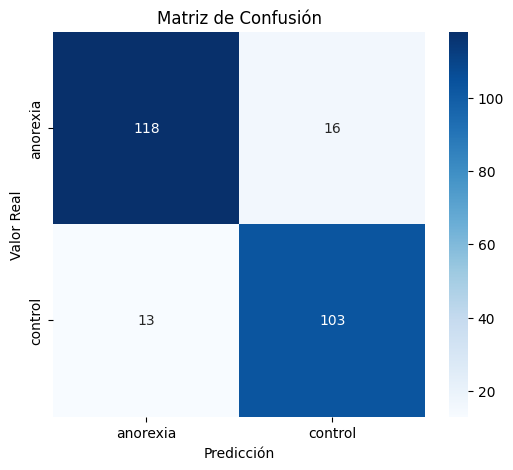

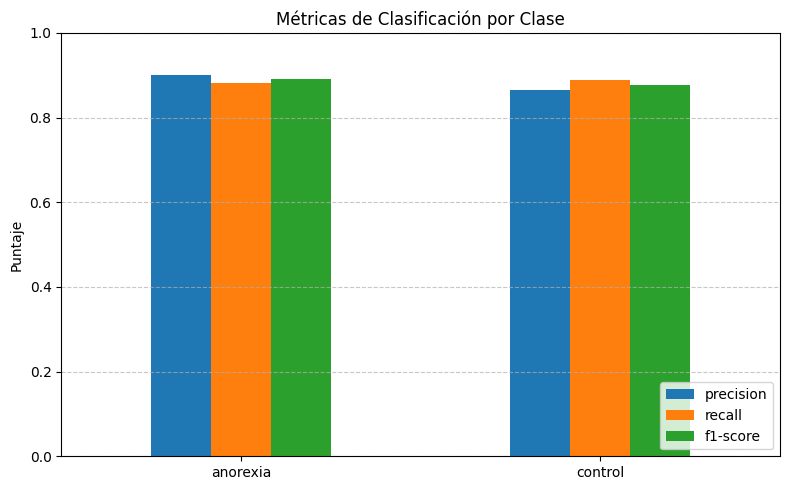

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Definimos las clases en el mismo orden que se usarán en los gráficos
labels = ["anorexia", "control"]

# Generamos la matriz de confusión usando las etiquetas reales y predichas
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Visualizamos la matriz de confusión como un mapa de calor
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Generamos el reporte de clasificación y lo convertimos en DataFrame
report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().loc[labels][['precision', 'recall', 'f1-score']]

# Visualizamos las métricas de clasificación como gráfico de barras
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title('Métricas de Clasificación por Clase')
plt.ylabel('Puntaje')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


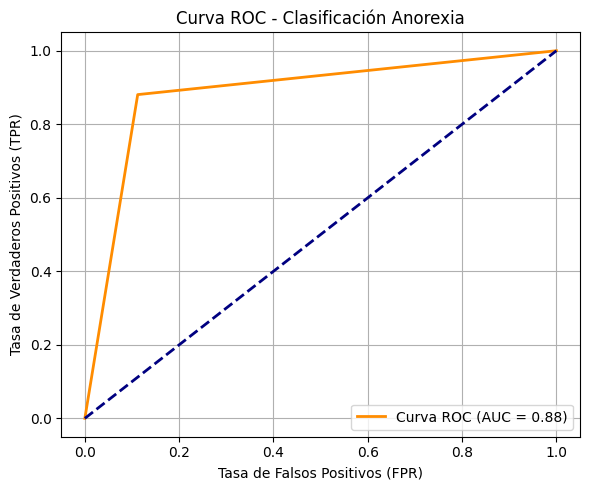

In [9]:
from sklearn.metrics import roc_curve, auc

# Cargar el archivo de resultados
resultados = pd.read_csv("resultados_modelo.csv")

# Convertir etiquetas a binario (1 = anorexia, 0 = control)
y_true_bin = (resultados['y_true'] == "anorexia").astype(int)
y_pred_bin = (resultados['y_pred'] == "anorexia").astype(int)

# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Anorexia')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\danir\AppData\Local\Temp\ipykernel_14920\1718343398.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados, x='error_tipo', palette='Set2')


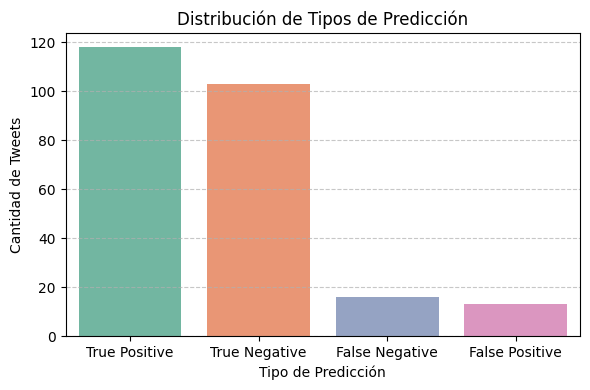

In [10]:
# Clasificar tipo de predicción
def clasificar_error(row):
    if row['y_true'] == 'anorexia' and row['y_pred'] == 'anorexia':
        return 'True Positive'
    elif row['y_true'] == 'control' and row['y_pred'] == 'control':
        return 'True Negative'
    elif row['y_true'] == 'control' and row['y_pred'] == 'anorexia':
        return 'False Positive'
    elif row['y_true'] == 'anorexia' and row['y_pred'] == 'control':
        return 'False Negative'
    else:
        return 'Otro'

resultados['error_tipo'] = resultados.apply(clasificar_error, axis=1)

# Gráfico de barras de errores
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=resultados, x='error_tipo', palette='Set2')
plt.title('Distribución de Tipos de Predicción')
plt.ylabel('Cantidad de Tweets')
plt.xlabel('Tipo de Predicción')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


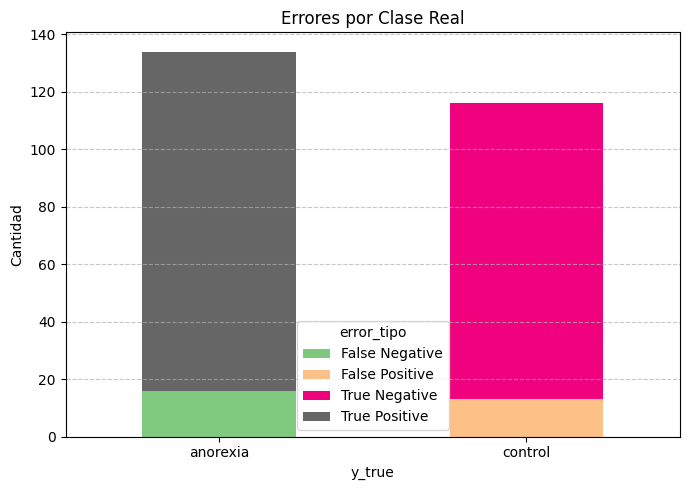

In [11]:
# Conteo por clase y tipo de error
conteo = resultados.groupby(['y_true', 'error_tipo']).size().unstack(fill_value=0)

# Gráfico
conteo.plot(kind='bar', stacked=True, figsize=(7, 5), colormap='Accent')
plt.title('Errores por Clase Real')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Prueba con el conjunto final de datos

Tweets en el conjunto final de prueba: 250


,user_id,tweet_id,tweet_text,class
68,user1612,5bac6873727e,Cena homenaje\nPorque yo lo valgo \n#lowcarbdi...,control
88,user1643,1fa76c5de46b,"Despues de las 7 nada debe entrar en la boca, ...",anorexia
23,user1535,eb93036a1f1c,#bajardepeso los mejores deportes para libera...,control
81,user1631,907074d85f7c,Sufro todos los dias. Pero amo la vida. Alguie...,anorexia
59,user1596,f25a90ee370e,Â¿Es verdad que al zumo de naranja se le van l...,control


100%|██████████| 250/250 [07:46<00:00,  1.87s/it]


=== Reporte de Clasificación ===
              precision    recall  f1-score   support

    anorexia       0.87      0.88      0.88       134
     control       0.86      0.85      0.86       116

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250


=== Matriz de Confusión ===
[[118  16]
 [ 17  99]]


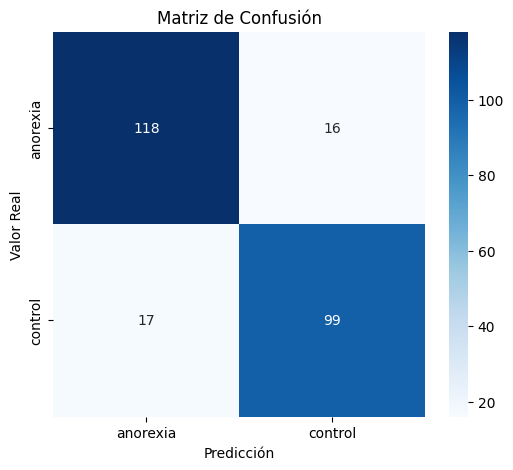

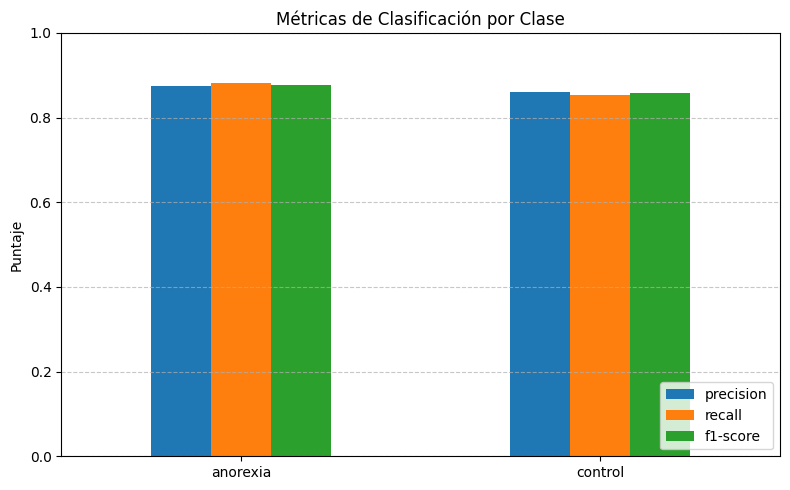

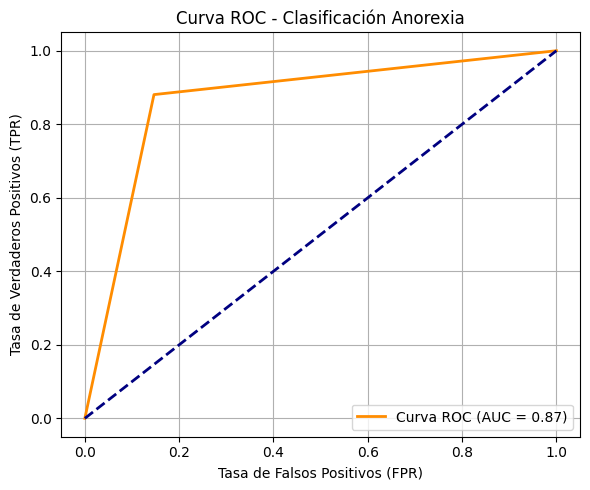

C:\Users\danir\AppData\Local\Temp\ipykernel_14920\1231256925.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=resultados_final, x='error_tipo', palette='Set2')


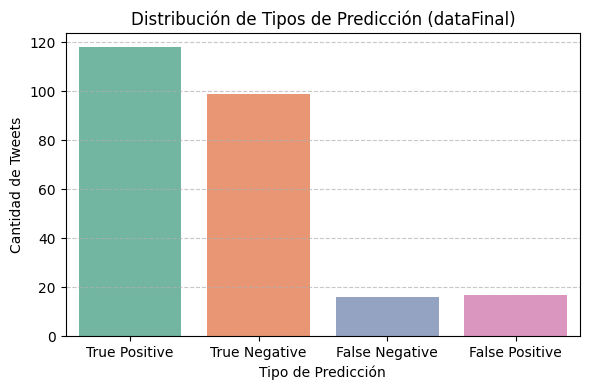

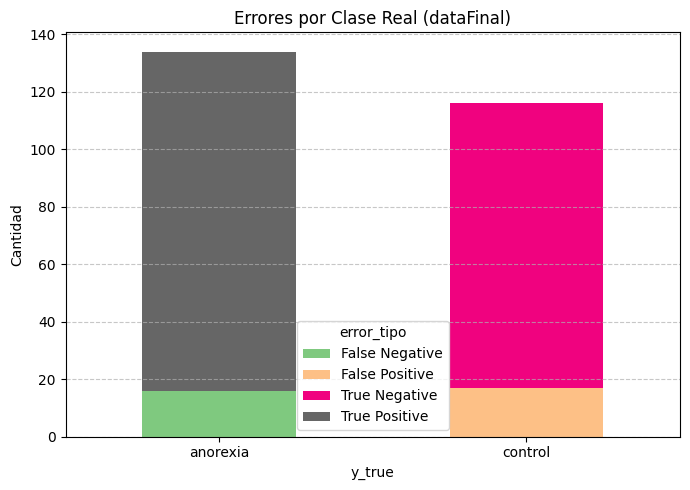

In [12]:
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Cargar el archivo final
dataFinal = pd.read_csv("../data/data_test_fold2.csv")

# Mostrar tamaño y ejemplos
print(f"Tweets en el conjunto final de prueba: {len(dataFinal)}")
display(dataFinal.sample(5))

# Inicializar listas para etiquetas verdaderas y predicciones
y_true_final = []
y_pred_final = []

# Evaluación
for _, row in tqdm(dataFinal.iterrows(), total=len(dataFinal)):
    texto = row["tweet_text"]
    etiqueta_real = row["class"]

    prompt = buildPrompt(texto)
    respuesta = preguntarAOllama(prompt).lower().strip()

    if "anorexia" in respuesta:
        pred = "anorexia"
    elif "control" in respuesta:
        pred = "control"
    else:
        pred = "indefinido"

    y_true_final.append(etiqueta_real)
    y_pred_final.append(pred)

    time.sleep(1.5)

# Reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_true_final, y_pred_final, labels=["anorexia", "control"]))

# Matriz de confusión
print("\n=== Matriz de Confusión ===")
print(confusion_matrix(y_true_final, y_pred_final, labels=["anorexia", "control"]))

# ---------- VISUALIZACIONES ---------- #

labels = ["anorexia", "control"]

# Matriz de confusión
cm = confusion_matrix(y_true_final, y_pred_final, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Métricas
report = classification_report(y_true_final, y_pred_final, labels=labels, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().loc[labels][['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title('Métricas de Clasificación por Clase')
plt.ylabel('Puntaje')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# AUC
y_true_bin_final = [1 if y == "anorexia" else 0 for y in y_true_final]
y_pred_bin_final = [1 if y == "anorexia" else 0 for y in y_pred_final]

fpr, tpr, _ = roc_curve(y_true_bin_final, y_pred_bin_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Anorexia')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# DataFrame de resultados
resultados_final = pd.DataFrame({
    'tweet_text': dataFinal['tweet_text'],
    'y_true': y_true_final,
    'y_pred': y_pred_final
})

# Clasificación de errores
def clasificar_error(row):
    if row['y_true'] == 'anorexia' and row['y_pred'] == 'anorexia':
        return 'True Positive'
    elif row['y_true'] == 'control' and row['y_pred'] == 'control':
        return 'True Negative'
    elif row['y_true'] == 'control' and row['y_pred'] == 'anorexia':
        return 'False Positive'
    elif row['y_true'] == 'anorexia' and row['y_pred'] == 'control':
        return 'False Negative'
    else:
        return 'Otro'

resultados_final['error_tipo'] = resultados_final.apply(clasificar_error, axis=1)

# Gráfico de tipos de predicción
plt.figure(figsize=(6, 4))
sns.countplot(data=resultados_final, x='error_tipo', palette='Set2')
plt.title('Distribución de Tipos de Predicción (dataFinal)')
plt.ylabel('Cantidad de Tweets')
plt.xlabel('Tipo de Predicción')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico de errores por clase
conteo_final = resultados_final.groupby(['y_true', 'error_tipo']).size().unstack(fill_value=0)
conteo_final.plot(kind='bar', stacked=True, figsize=(7, 5), colormap='Accent')
plt.title('Errores por Clase Real (dataFinal)')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()